<a href="https://colab.research.google.com/github/Madelinelai/CNN-RNN/blob/main/2_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

第一部分：

介紹如何用 PyTorch 訓練自己的 convolutional neural network

第二部份：

1. 資料預處理
1. 資料增強 (data augmentation)
1. 測試時的資料增強 (test time augmentation)

第三部份：

預訓練模型


In [ ]:
!pip freeze | grep albumentations

albumentations==0.1.12


In [ ]:
!pip install albumentations==0.4.3
!pip install matplotlib==3.1.3
!pip install numpy==1.18.2
!pip install torch==1.4.0
!pip install torchvision==0.5.0

     |████████████████████████████████| 3.2MB 7.0MB/s 
     |████████████████████████████████| 634kB 42.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.3-cp37-none-any.whl size=60780 sha256=a3da0e0da80d4212bbac4e19748cd5bb19e30a4f17c3f7de5770e842030d7cdf
  Stored in directory: /root/.cache/pip/wheels/20/16/8e/d3bec34bf30adff30929226f0b83cc8c005b5af131f51db9d0
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=23547c722f677ce10f7055fb2d56628381fd97cf64687c51a60c6ecc0c9d8d41
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 13.1MB 227

     |████████████████████████████████| 20.2MB 7.7MB/s 
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement numpy>=1.18.5, but you'll have numpy 1.18.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


     |████████████████████████████████| 753.4MB 24kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:

      Successfully uninstalled torch-1.9.0+cu102
     |████████████████████████████████| 4.0MB 8.6MB/s 
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [ ]:
import os
import platform
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# 下載 cifar 10 影像資料並解壓縮
# cifar 10 介紹：https://www.cs.toronto.edu/~kriz/cifar.html
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 

--2021-07-16 15:38:49--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  44.1MB/s    in 4.1s    

2021-07-16 15:38:53 (39.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)
0.0 255.0


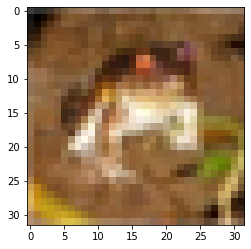

In [ ]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin-1')
    # print(datadict)
    feature = datadict['data']
    label = datadict['labels']
    feature = feature.reshape(10000, 3, 32, 32).astype("float")
    label = np.array(label)
    return feature, label

cifar_dir = 'cifar-10-batches-py'
train_feature = []
train_label = []
for i in range(5):
    f = os.path.join(cifar_dir, 'data_batch_%d' % (i + 1))
    feature_i, label_i = load_batch(f)
    train_feature.append(feature_i)
    train_label.append(label_i)
train_feature = np.concatenate(train_feature).transpose(0, 2, 3, 1)
train_label = np.concatenate(train_label)
del feature_i, label_i
test_feature, test_label = load_batch(os.path.join(cifar_dir, 'test_batch'))
test_feature = test_feature.transpose(0, 2, 3, 1)

print(train_feature.shape, train_label.shape, test_feature.shape, test_label.shape)
print(train_feature[0].min(), train_feature[0].max())
# channel, x, y to x, y, channel
plt.imshow(train_feature[0].astype(np.uint8))

In [ ]:
# 切出訓練集跟驗證集
np.random.seed(551335114)
index = np.arange(train_feature.shape[0])
np.random.shuffle(index)

train_feature, val_feature = train_feature[index[:45000]], train_feature[index[45000:]]
train_label, val_label = train_label[index[:45000]], train_label[index[45000:]]


建立訓練環境：

1. 寫好模型

1. 寫好讀取資料的 Dataset class

1. 將資料逐一讀出訓練模型

In [ ]:
# 建立自己的 CNN
# 圖片輸入 => conv => relu => pooling => conv => pooling => feedforward (fully connected)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)
        # 可以用 https://pytorch.org/docs/stable/nn.html#torch.nn.AdaptiveMaxPool2d 就不用算維度算得這麼辛苦
        self.fc = nn.Linear(25 * 64, 10)
    
    def forward(self, x):
        # x = batch_size x 3 x 32 x 32
        x = F.relu(self.conv1(x), 2)
        # x = batch_size x 64 x 28 x 28
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # x = batch_size x 64 x 14 x 14
        x = F.relu(self.conv2(x), 2)
        # x = batch_size x 64 x 10 x 10
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # x = batch_size x 64 x 5 x 5 (除不盡會被捨去 https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d )
        # flatten, 變成二維 -1 表示自動計算，25(= 5 x 5) 是圖的大小，64 是 conv2 output 64 個 filter
        # 變成 batch_size x 1600
        x = x.view(-1, 25 * 64)
        x = self.fc(x)
        return x
  

In [ ]:
class CifarDataset(Dataset):
    def __init__(self, feature, label=None, train_mean=None, train_std=None):
        self.feature = feature
        self.label = label
        self.train_mean = train_mean
        self.train_std = train_std
    
    def __getitem__(self, idx):
        feature = self.feature[idx]
        if self.train_mean is not None and self.train_std is not None:
            feature = (feature - self.train_mean) / self.train_std
        # PyTorch 使用 (channel, height, width)
        feature = np.transpose(feature, (2, 0, 1))
        if self.label is not None:
            return feature, self.label[idx]
        else:
            return feature
    
    def __len__(self):
        return self.feature.shape[0]

# **Cross entropy loss**

https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html

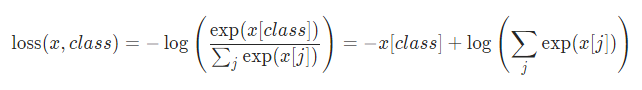


In [ ]:
def train_model(model_class, train_dataset, val_dataset, max_epoch=100, patient=5, lr=1e-3, name=None, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    best_loss = np.inf
    best_epoch = -1
    # optimize cross entropy loss
    # https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html
    criterion = nn.CrossEntropyLoss()
    model = model_class()
    # print(model)
    model.cuda()  # 使用 GPU
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(max_epoch):
        model.train()  # 訓練模式
        train_loss = 0.0
        train_correct = 0
        # 通常深度學習使用的資料量都很大，無法一次讀入 GPU，所以每次只訓練 batch_size 筆資料
        for feature, label in train_loader:
            feature = feature.to(torch.device('cuda')).float()
            label = label.to(torch.device('cuda'))
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                output = model(feature)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
            label = label.cpu().numpy()
            pred = np.argmax(output.detach().cpu().numpy(), axis=1)
            train_loss += loss.item() * label.shape[0]
            train_correct += np.sum(label == pred)
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        print('Epoch %d train loss %f accuracy %.4f' % (epoch, train_loss, train_acc))

        model.eval()  # 預測模式
        val_loss = 0.0
        val_correct = 0
        for feature, label in val_loader:
            feature = feature.to(torch.device('cuda')).float()
            label = label.to(torch.device('cuda'))
            with torch.set_grad_enabled(False):
                if len(feature.size()) == 5:  # test time augmentation 用
                    B, T, C, H, W = feature.size()
                    output = model(feature.view(-1, C, H, W))
                    output = output.view(B, T, -1)
                    output = output.mean(dim=1)
                else:
                    output = model(feature)
                loss = criterion(output, label)
            label = label.cpu().numpy()
            pred = np.argmax(output.cpu().numpy(), axis=1)
            val_loss += loss.item() * label.shape[0]
            val_correct += np.sum(label == pred)
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        print('Epoch %d validation loss %f accuracy %.4f' % (epoch, val_loss, val_acc))

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            # 儲存當前 validation 最好的模型
            if name is not None:
                torch.save({'model': model.state_dict()}, name)

        if epoch - best_epoch >= patient:
            # 當 patient 個 epoch 沒有進步後，跳出迴圈停止訓練
            print('Best epoch %d' % best_epoch)
            break

def eval_model(model, test_dataset, batch_size=64):
    criterion = nn.CrossEntropyLoss()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    loss = 0.0
    correct = 0
    for feature, label in test_loader:
        feature = feature.to(torch.device('cuda')).float()
        label = label.to(torch.device('cuda'))
        with torch.set_grad_enabled(False):
            if len(feature.size()) == 5:  # test time augmentation 用
                B, T, C, H, W = feature.size()
                output = model(feature.view(-1, C, H, W))
                output = output.view(B, T, -1)
                output = output.mean(dim=1)
            else:
                output = model(feature)
        label = label.cpu().numpy()
        pred = np.argmax(output.cpu().numpy(), axis=1)
        correct += np.sum(label == pred)
    acc = correct / len(test_loader.dataset)
    print('Test accuracy %.4f' % acc)

In [ ]:
train_dataset = CifarDataset(train_feature, train_label)
val_dataset = CifarDataset(val_feature, val_label)
test_dataset = CifarDataset(test_feature, test_label)

train_model(ConvNet, train_dataset, val_dataset, name='model.ckpt')
model_ckpt = torch.load('model.ckpt')
model = ConvNet()
model.cuda()
model.load_state_dict(model_ckpt['model'])
eval_model(model, test_dataset)


Epoch 0 train loss 2.353386 accuracy 0.2661
Epoch 0 validation loss 1.588211 accuracy 0.4306
Epoch 1 train loss 1.476576 accuracy 0.4694
Epoch 1 validation loss 1.444263 accuracy 0.4898
Epoch 2 train loss 1.361184 accuracy 0.5208
Epoch 2 validation loss 1.413498 accuracy 0.5036
Epoch 3 train loss 1.286010 accuracy 0.5497
Epoch 3 validation loss 1.266479 accuracy 0.5506
Epoch 4 train loss 1.233907 accuracy 0.5677
Epoch 4 validation loss 1.245590 accuracy 0.5644
Epoch 5 train loss 1.192825 accuracy 0.5862
Epoch 5 validation loss 1.219138 accuracy 0.5814
Epoch 6 train loss 1.151678 accuracy 0.6018
Epoch 6 validation loss 1.292943 accuracy 0.5624
Epoch 7 train loss 1.117889 accuracy 0.6125
Epoch 7 validation loss 1.240648 accuracy 0.5724
Epoch 8 train loss 1.087696 accuracy 0.6278
Epoch 8 validation loss 1.267286 accuracy 0.5732
Epoch 9 train loss 1.085124 accuracy 0.6266
Epoch 9 validation loss 1.297099 accuracy 0.5742
Epoch 10 train loss 1.073895 accuracy 0.6302
Epoch 10 validation loss 

成效不理想，出了什麼問題？ (To be continue)

**重要！將輸入 normalize 到 mean 0 std 1, 增加數值穩定度**

In [ ]:
train_mean = np.mean(train_feature, axis=(0, 1, 2))
train_std = 0.0
for i in range(train_feature.shape[0]):
    train_std += np.std(train_feature[i], axis=(0, 1))
train_std /= train_feature.shape[0]
print(train_mean, train_std)

train_dataset = CifarDataset(train_feature, train_label, train_mean=train_mean, train_std=train_std)
val_dataset = CifarDataset(val_feature, val_label, train_mean=train_mean, train_std=train_std)
test_dataset = CifarDataset(test_feature, test_label, train_mean=train_mean, train_std=train_std)

train_model(ConvNet, train_dataset, val_dataset, name='model.ckpt')
model_ckpt = torch.load('model.ckpt')
model = ConvNet()
model.cuda()
model.load_state_dict(model_ckpt['model'])
eval_model(model, test_dataset)


[125.26686406 122.93561814 113.87160816] [51.56650806 50.83678305 51.24483007]
Epoch 0 train loss 1.403102 accuracy 0.4997
Epoch 0 validation loss 1.209732 accuracy 0.5894
Epoch 1 train loss 1.079814 accuracy 0.6224
Epoch 1 validation loss 1.039771 accuracy 0.6378
Epoch 2 train loss 0.951679 accuracy 0.6718
Epoch 2 validation loss 0.938765 accuracy 0.6818
Epoch 3 train loss 0.872921 accuracy 0.7002
Epoch 3 validation loss 0.939741 accuracy 0.6728
Epoch 4 train loss 0.816147 accuracy 0.7178
Epoch 4 validation loss 0.897427 accuracy 0.6866
Epoch 5 train loss 0.769172 accuracy 0.7355
Epoch 5 validation loss 0.904213 accuracy 0.6918
Epoch 6 train loss 0.728024 accuracy 0.7468
Epoch 6 validation loss 0.888325 accuracy 0.7024
Epoch 7 train loss 0.703850 accuracy 0.7561
Epoch 7 validation loss 0.869151 accuracy 0.7038
Epoch 8 train loss 0.666076 accuracy 0.7652
Epoch 8 validation loss 0.870893 accuracy 0.7080
Epoch 9 train loss 0.647185 accuracy 0.7750
Epoch 9 validation loss 0.909803 accurac

Data Augmentation

因為類神經網路通常參數很多，需要大量資料來訓練，一般都會做 data augmentation 增加資料量

以影像來說，就是做旋轉、縮放、翻轉等，稍微改變影像，但是不影響他的答案或是要知道新的答案(為什麼？)


In [ ]:
# 這邊使用 albumentations 做 data augmentation
from albumentations import Compose, Normalize, GaussianBlur, ShiftScaleRotate, HorizontalFlip, PadIfNeeded, CenterCrop


class AugmentedDataset(Dataset):
    def __init__(self, feature, label=None, train_mean=None, train_std=None, transform=[]):
        self.feature = feature
        self.label = label
        self.train_mean = train_mean
        self.train_std = train_std
        self.transform = transform
    
    def __getitem__(self, idx):
        feature = self.feature[idx]
        if self.train_mean is not None and self.train_std is not None:
            feature = (feature - self.train_mean) / self.train_std
        feature = Compose(self.transform)(image=feature)['image']
        feature = np.transpose(feature, (2, 0, 1))
        if self.label is not None:
            return feature, self.label[idx]
        else:
            return feature
    
    def __len__(self):
        return self.feature.shape[0]

In [ ]:
transform = [
    ShiftScaleRotate(shift_limit=0.0, scale_limit=0.2, rotate_limit=2.5, p=0.5),
    HorizontalFlip(p=0.5),  # 文字資料(中、英、日文等)不能 flip，為什麼？
    # GaussianBlur(blur_limit=3, p=1.0),  #  如果圖片大一點可以考慮加 Gaussian Blur
    PadIfNeeded(min_height=32, min_width=32, p=1.0),
    CenterCrop(height=32, width=32),
]
train_dataset = AugmentedDataset(train_feature, train_label, train_mean=train_mean, train_std=train_std, transform=transform)
val_dataset = CifarDataset(val_feature, val_label, train_mean=train_mean, train_std=train_std)
test_dataset = CifarDataset(test_feature, test_label, train_mean=train_mean, train_std=train_std)

train_model(ConvNet, train_dataset, val_dataset, name='model.ckpt')
model_ckpt = torch.load('model.ckpt')
model = ConvNet()
model.cuda()
model.load_state_dict(model_ckpt['model'])
eval_model(model, test_dataset)


Epoch 0 train loss 1.451866 accuracy 0.4809
Epoch 0 validation loss 1.241139 accuracy 0.5548
Epoch 1 train loss 1.162299 accuracy 0.5939
Epoch 1 validation loss 1.101607 accuracy 0.6124
Epoch 2 train loss 1.067289 accuracy 0.6305
Epoch 2 validation loss 1.043179 accuracy 0.6362
Epoch 3 train loss 1.011618 accuracy 0.6484
Epoch 3 validation loss 0.992615 accuracy 0.6530
Epoch 4 train loss 0.968768 accuracy 0.6663
Epoch 4 validation loss 1.000878 accuracy 0.6626
Epoch 5 train loss 0.937565 accuracy 0.6766
Epoch 5 validation loss 0.925367 accuracy 0.6824
Epoch 6 train loss 0.914794 accuracy 0.6841
Epoch 6 validation loss 0.908713 accuracy 0.6810
Epoch 7 train loss 0.888267 accuracy 0.6928
Epoch 7 validation loss 0.896639 accuracy 0.6896
Epoch 8 train loss 0.874781 accuracy 0.6973
Epoch 8 validation loss 0.936717 accuracy 0.6792
Epoch 9 train loss 0.860663 accuracy 0.7018
Epoch 9 validation loss 0.890760 accuracy 0.6992
Epoch 10 train loss 0.850037 accuracy 0.7052
Epoch 10 validation loss 

Test Time Augmentation (TTA):

預測時使用多張圖片，並將他們的預測值做平均

In [ ]:
class TTADataset(Dataset):
    def __init__(self, feature, label=None, train_mean=None, train_std=None, transform=[]):
        self.feature = feature
        self.label = label
        self.train_mean = train_mean
        self.train_std = train_std
        self.transform = transform
    
    def __getitem__(self, idx):
        feature = self.feature[idx]
        if self.train_mean is not None and self.train_std is not None:
            feature = (feature - self.train_mean) / self.train_std
        features = [feature]
        features.append(HorizontalFlip(always_apply=True)(image=feature)['image'])
        features = np.stack(features, axis=0)
        features = np.transpose(features, (0, 3, 1, 2))
        if self.label is not None:
            return features, self.label[idx]
        else:
            return features
    
    def __len__(self):
        return self.feature.shape[0]
  
val_dataset = TTADataset(val_feature, val_label, train_mean=train_mean, train_std=train_std)
test_dataset = TTADataset(test_feature, test_label, train_mean=train_mean, train_std=train_std)

model_ckpt = torch.load('model.ckpt')
model = ConvNet()
model.cuda()
model.load_state_dict(model_ckpt['model'])
eval_model(model, val_dataset)
eval_model(model, test_dataset)


Test accuracy 0.7470
Test accuracy 0.7403


預訓練模型 (Pretrained Model)

使用 Imagenet 資料預先訓練好的模型

什麼是 Imagenet：http://www.image-net.org/ https://zh.wikipedia.org/zh-tw/ImageNet

PyTorch 內建：https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
from torchvision import models

class Resnet(nn.Module):
    def __init__(self, n_class=10):
        super(Resnet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, n_class)

    def forward(self, x):
        return self.model.forward(x)

class ResnetScratch(nn.Module):
    def __init__(self, n_class=10):
        super(ResnetScratch, self).__init__()
        self.model = models.resnet18(pretrained=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, n_class)

    def forward(self, x):
        return self.model.forward(x)


In [ ]:
transform = [
    ShiftScaleRotate(shift_limit=0.0, scale_limit=0.2, rotate_limit=2.5, p=0.5),
    HorizontalFlip(p=0.5),  # 文字資料(中、英、日文等)不能 flip，為什麼？
    # GaussianBlur(blur_limit=3, p=1.0),  #  如果圖片大一點可以考慮加 Gaussian Blur
    PadIfNeeded(min_height=32, min_width=32, p=1.0),
    CenterCrop(height=32, width=32),
]
train_dataset = AugmentedDataset(train_feature, train_label, train_mean=train_mean, train_std=train_std, transform=transform)
val_dataset = TTADataset(val_feature, val_label, train_mean=train_mean, train_std=train_std)
test_dataset = TTADataset(test_feature, test_label, train_mean=train_mean, train_std=train_std)

train_model(ResnetScratch, train_dataset, val_dataset, name='model.ckpt')
model_ckpt = torch.load('model.ckpt')
model = ResnetScratch()
model.cuda()
model.load_state_dict(model_ckpt['model'])
eval_model(model, test_dataset)

# imagenet pretrained 用的 mean / std https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
imagenet_mean = np.array([0.485, 0.456, 0.406]) * 255
imagenet_std = np.array([0.229, 0.224, 0.225]) * 255
train_dataset = AugmentedDataset(train_feature, train_label, train_mean=imagenet_mean, train_std=imagenet_std, transform=transform)
val_dataset = TTADataset(val_feature, val_label, train_mean=imagenet_mean, train_std=imagenet_std)
test_dataset = TTADataset(test_feature, test_label, train_mean=imagenet_mean, train_std=imagenet_std)

train_model(Resnet, train_dataset, val_dataset, name='model.ckpt')
model_ckpt = torch.load('model.ckpt')
model = Resnet()
model.cuda()
model.load_state_dict(model_ckpt['model'])
eval_model(model, test_dataset)

Epoch 0 train loss 1.447758 accuracy 0.4808
Epoch 0 validation loss 1.105800 accuracy 0.6180
Epoch 1 train loss 1.080669 accuracy 0.6214
Epoch 1 validation loss 0.946029 accuracy 0.6682
Epoch 2 train loss 0.921757 accuracy 0.6816
Epoch 2 validation loss 0.816221 accuracy 0.7074
Epoch 3 train loss 0.813312 accuracy 0.7184
Epoch 3 validation loss 0.757172 accuracy 0.7358
Epoch 4 train loss 0.735773 accuracy 0.7462
Epoch 4 validation loss 0.714444 accuracy 0.7502
Epoch 5 train loss 0.710436 accuracy 0.7516
Epoch 5 validation loss 0.660476 accuracy 0.7712
Epoch 6 train loss 0.626385 accuracy 0.7810
Epoch 6 validation loss 0.651326 accuracy 0.7720
Epoch 7 train loss 0.580681 accuracy 0.7997
Epoch 7 validation loss 0.580399 accuracy 0.8002
Epoch 8 train loss 0.540950 accuracy 0.8119
Epoch 8 validation loss 0.572364 accuracy 0.8008
Epoch 9 train loss 0.502599 accuracy 0.8274
Epoch 9 validation loss 0.633677 accuracy 0.7878
Epoch 10 train loss 0.465658 accuracy 0.8386
Epoch 10 validation loss 

比 Imagenet 更厲害的預訓練模型：Instagram pretrained https://github.com/facebookresearch/WSL-Images (ECCV 2018 by Facebook team)